# Custom SHAP plots

创建超出 SHAP 软件包提供范围的自定义绘图

Dataset: https://archive.ics.uci.edu/ml/datasets/Abalone

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
plt.style.use('default')
%matplotlib inline

import seaborn as sns

import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score,confusion_matrix

import shap
shap.initjs()

import os
dp = os.environ.get('pub_data')

## Data

In [2]:
# import dataset
data = pd.read_csv(dp + 'Abalone dataset/abalone.data',
                  names=['sex','length','diameter','height','whole weight','shucked weight','viscera weight','shell weight','rings'])

y = data['rings']
X = data.drop('rings', axis=1)

# Create dummy variables
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex', axis=1)


print(len(data))
data.head()

4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Model

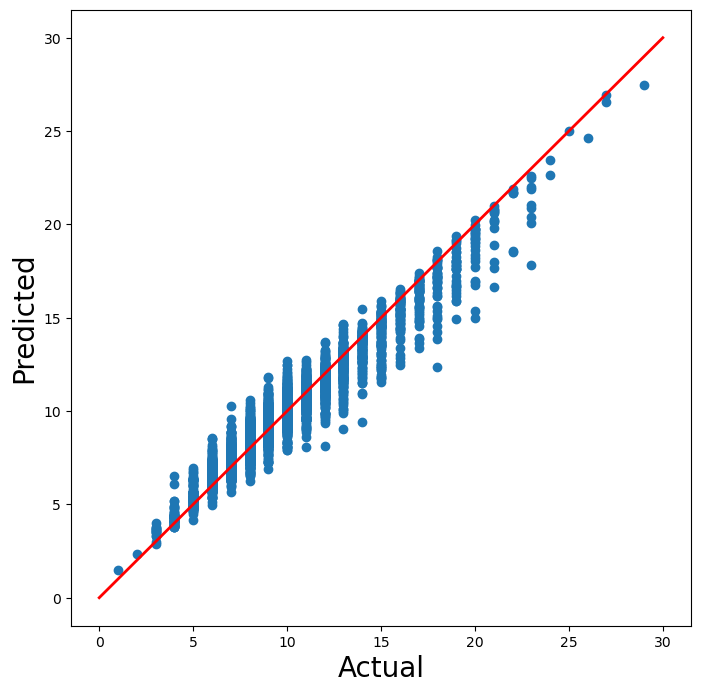

In [3]:
# Train model
model = xgb.XGBRegressor(objective="reg:squarederror") 
model.fit(X, y)

# Get predictions
y_pred = model.predict(X)

# Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y,y_pred)
plt.plot([0, 30], [0, 30], color='r', linestyle='-', linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

plt.savefig('../../figures/regression_evaluation.png' ,dpi=200,bbox_inches='tight')

## SHAP values

In [4]:
# Get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

### Plot 1: SHAP Correlation

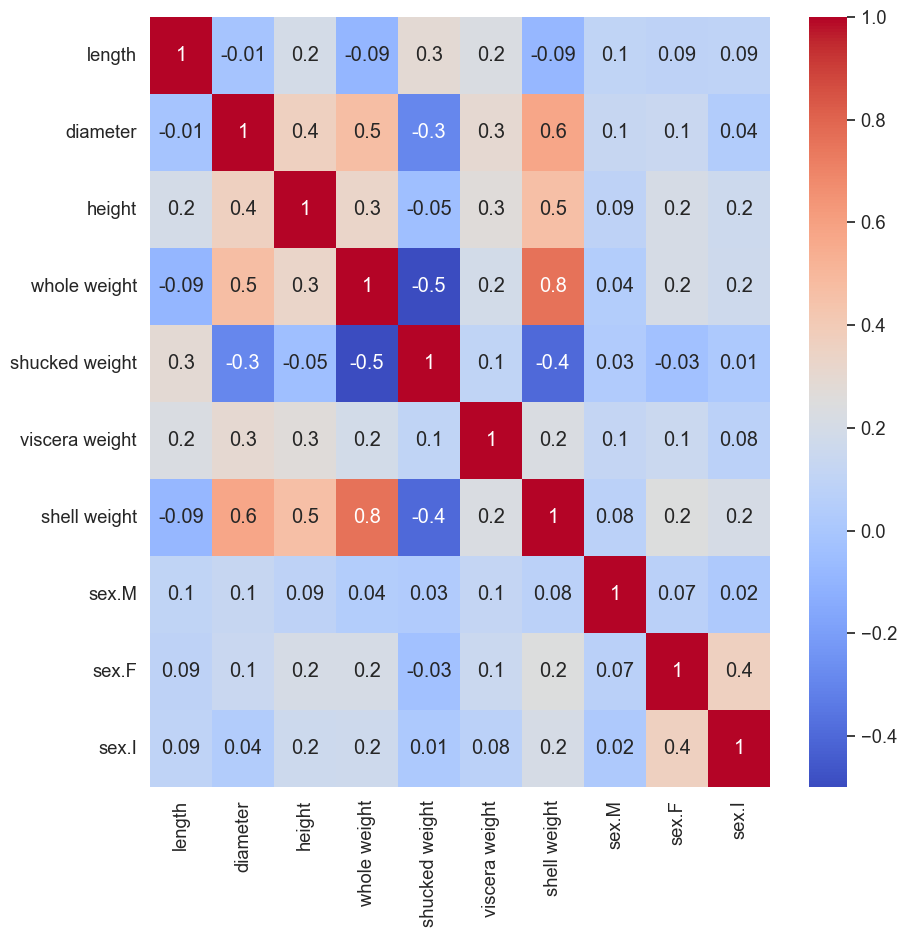

In [5]:
# SHAP correlation plot 
corr_matrix = pd.DataFrame(shap_values.values,columns=X.columns).corr()

# Display Correlations
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix,cmap='coolwarm',annot=True,fmt='.1g')

plt.savefig('../../figures/shap_correlation.png', dpi=200,bbox_inches='tight')

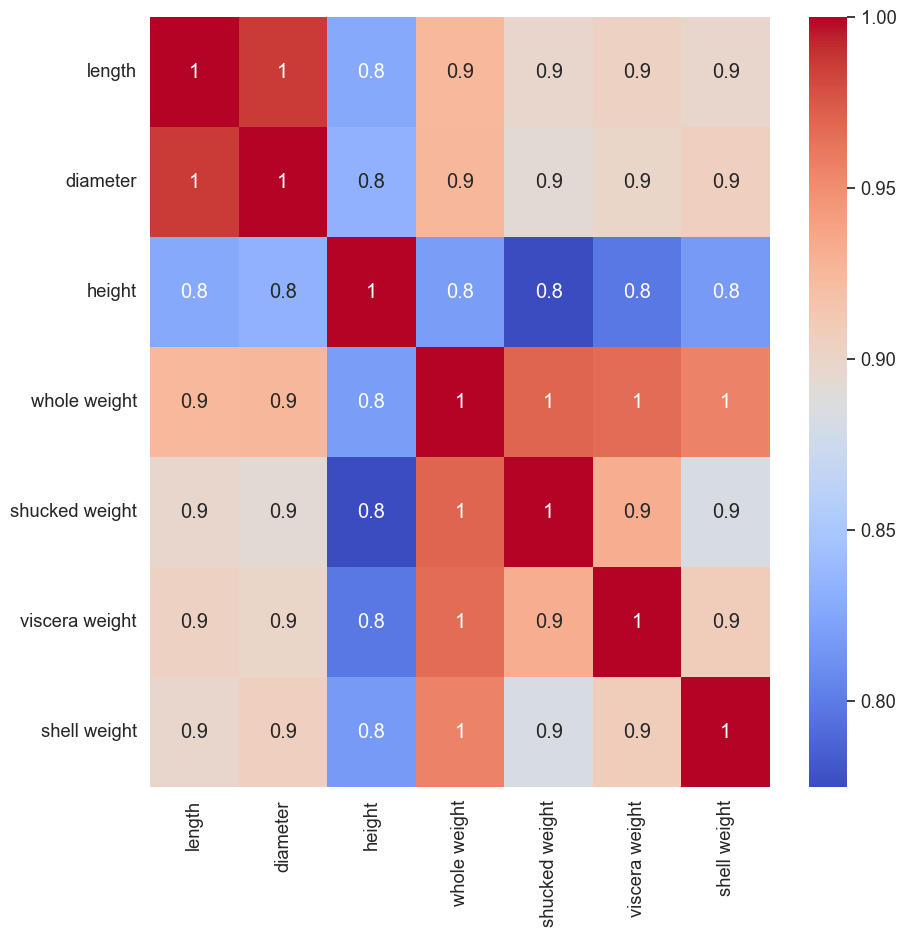

In [6]:
# Standard correlation plot 
cont = ["length","diameter","height","whole weight","shucked weight","viscera weight","shell weight"]
corr_matrix = pd.DataFrame(X[cont],columns=cont).corr()

# Display Correlations
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix,cmap='coolwarm',annot=True,fmt='.1g')

plt.savefig('../../figures/standard_correlation.png',dpi=200,bbox_inches='tight')

### Plot 2: Waterfall + feature range

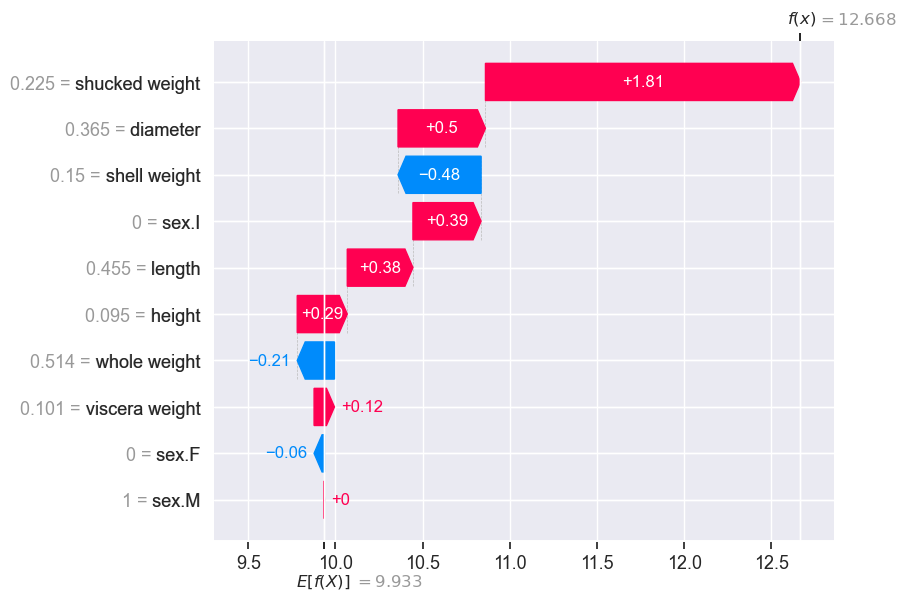

In [7]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

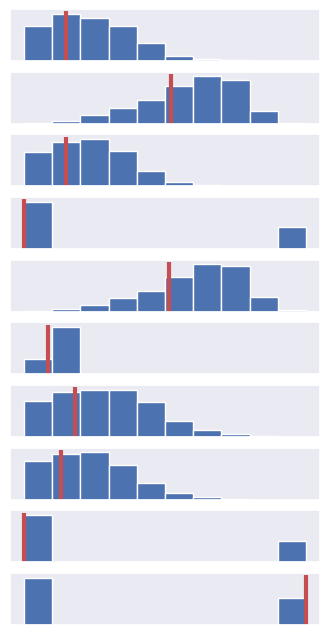

In [8]:
x = 0 # Observation 

fig, ax = plt.subplots(nrows=10, ncols=1,figsize=(4,8))

features = ['shucked weight','diameter','shell weight','sex.I','length',
'height','whole weight','viscera weight', 'sex.F','sex.M'] 

for i,f in enumerate(features):
    
    # Plot histogram
    ax[i].hist(X[f])
    ymin, ymax = ax[i].get_ylim()
    ax[i].vlines(X[f][x],0,ymax,colors='r',linewidth=3)
    ax[i].set_yticks([])
    ax[i].set_xticks([])

plt.savefig('../../figures/feature_values1.png', dpi=200,bbox_inches='tight')

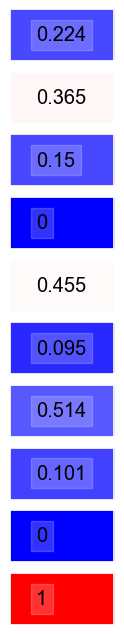

In [9]:
x = 0 # Observation 

fig, ax = plt.subplots(nrows=10, ncols=1,figsize=(4,8))

features = ['shucked weight','diameter','shell weight','sex.I','length',
'height','whole weight','viscera weight', 'sex.F','sex.M'] 

for i,f in enumerate(features):
    
    value = round(X[f][x],3)
    data = [[value]*2]

    cmap = plt.get_cmap('bwr')
    bounds = np.linspace(min(X[f]),max(X[f]),100)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax[i].imshow(data, cmap=cmap, norm=norm)
    ax[i].text(0,0.1,s=value,c='black',bbox=dict(facecolor='white', alpha=0.2))

    # Remove Ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.savefig('../../figures/feature_values2.png',dpi=200,bbox_inches='tight')

### Plot 3: Interaction heatmap

1000


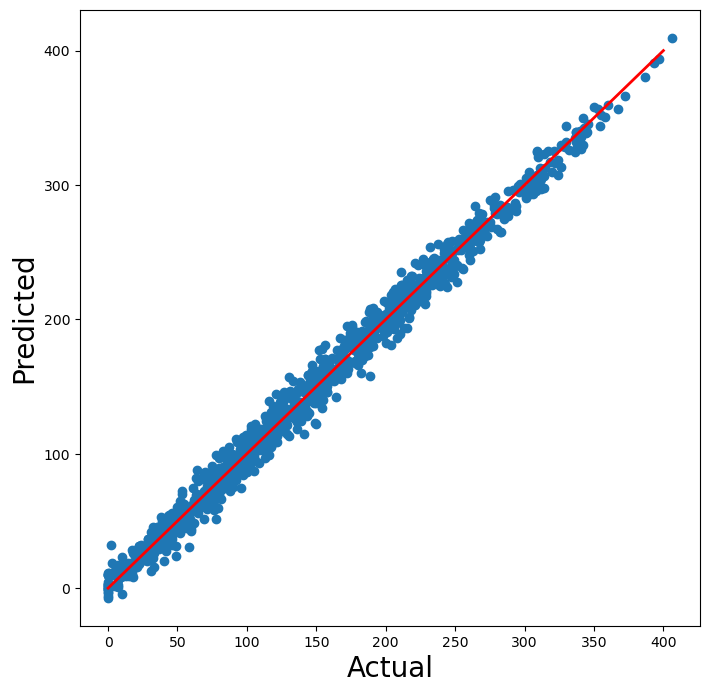

In [3]:
import warnings
# warnings.filterwarnings("ignore")

# Import dataset
data = pd.read_csv(dp + "interaction_dataset.csv",sep='\t')

y = data['bonus']
X = data.drop('bonus', axis=1)

print(len(data))

# Train model
model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=3) 
model.fit(X, y)

# Get predictions
y_pred = model.predict(X)

# Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y,y_pred)
plt.plot([0, 400], [0, 400], color='r', linestyle='-', linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

plt.savefig('../../figures/regression_evaluation.png', dpi=200,bbox_inches='tight')

In [4]:
# Get SHAP interaction values
explainer = shap.TreeExplainer(model)
shap_interaction = explainer.shap_interaction_values(X)

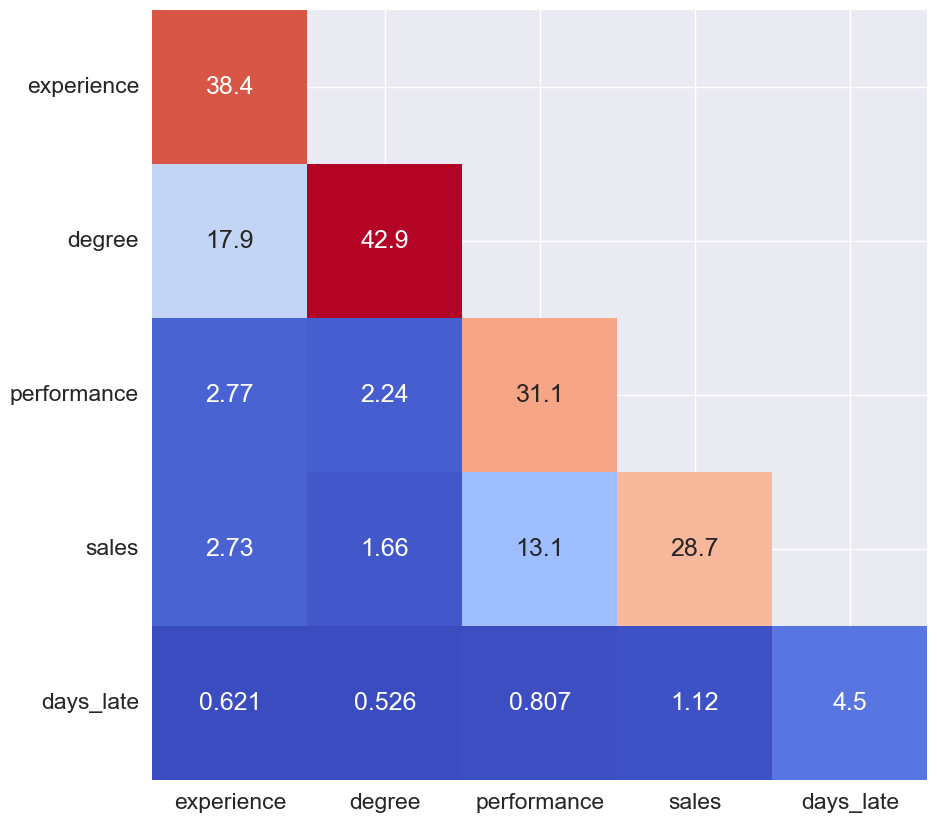

In [5]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# Define mask used to cover squares above diagonal 
mask = []
mask = np.triu(np.ones_like(df, dtype=bool), k=1)

# Display plot
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False,mask=mask)
plt.yticks(rotation=0) 

plt.savefig('../../figures/abs_mean_shap.png', dpi=200,bbox_inches='tight')

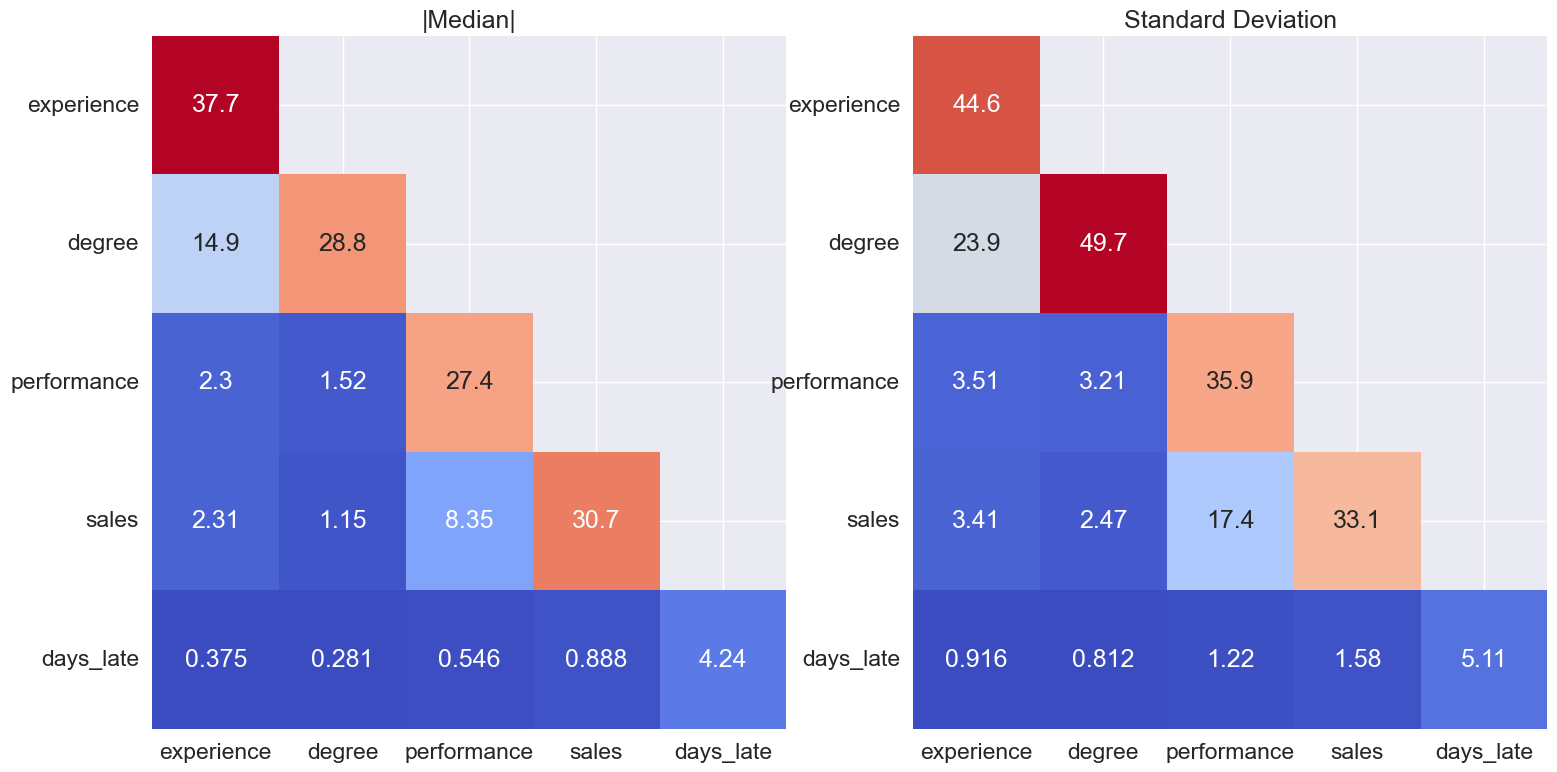

In [6]:
plt.figure(figsize=(18, 9))

# Plot 1: Absolute Median 
plt.subplot(121)
# Get absolute mean of matrices
mean_shap = np.median(np.abs(shap_interaction),axis=0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False,mask=mask)
plt.yticks(rotation=0) 
plt.title('|Median|')

#Plot 2: Standard Deviation
plt.subplot(122)

# Get absolute mean of matrices
mean_shap = np.std(shap_interaction,axis=0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False,mask=mask)
plt.yticks(rotation=0) 
plt.title('Standard Deviation')

plt.savefig('../../figures/heatmap_shap.png', dpi=200,bbox_inches='tight')

### Interaction Waterfall

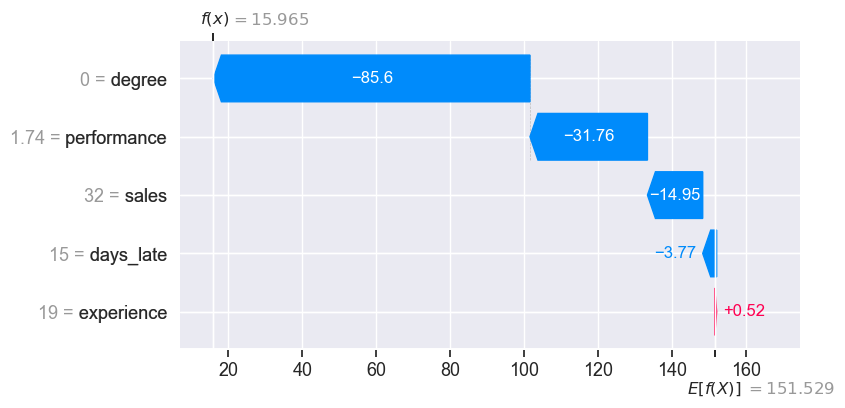

In [7]:
# Get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Interaction waterfall
shap.plots.waterfall(shap_values[0])

In [35]:
def flatten_shap(shap_interaction,features):
    
    shap_i = pd.DataFrame(shap_interaction,index=features,columns=features)

    flatten_values = [] #Flattened shap interaction matrix
    feature_names = [] 
    feature_data = [] # Feature values (0 for interactions)

    for i in range(len(features)):
        feat_i = features[i]
        for j in range(len(features)):
            feat_j = features[j]
            
            #Diagonals
            if feat_i == feat_j:
                flatten_values.append(shap_i[feat_i][feat_i])
                feature_names.append(feat_i)
                feature_data.append(X[feat_i][0])
                
            #Off-diagonals
            if feat_i != feat_j and i<j:
                flatten_values.append(shap_i[feat_i][feat_j]*2)
                feature_names.append('{}.{}'.format(feat_i,feat_j))
                feature_data.append(0)
                
    return flatten_values, feature_names, feature_data 
    

In [36]:
all_flatten_values = []
all_feature_names = []
all_feature_data = []

#Loop over all shap interaction matrices
for s in shap_interaction:
    flatten_values, feature_names, feature_data = flatten_shap(s,X.columns)
    all_flatten_values.append(flatten_values)
    all_feature_names.append(feature_names)
    all_feature_data.append(feature_data)

# Replace items in SHAP object
shap_values.values = np.array(all_flatten_values)
shap_values.feature_names = all_feature_names[0]
shap_values.data = np.array(all_feature_data)    


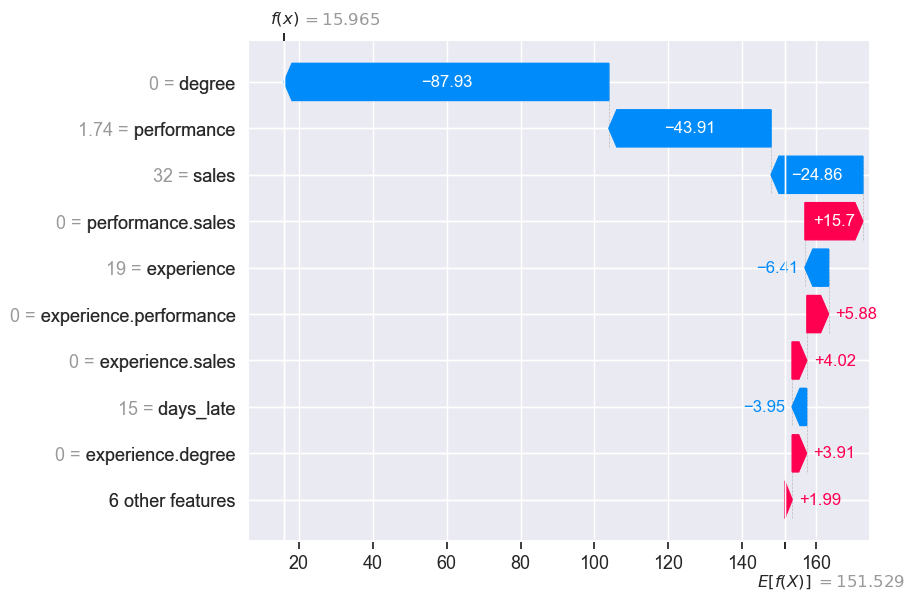

In [37]:
# Interaction waterfall
shap.plots.waterfall(shap_values[0])

In [38]:
# Interaction waterfall
shap.plots.force(shap_values[0])

## Archive

In [39]:
y_1 = [y_==1 for y_ in y]
X_1 = X[y_1]
#X_1 = X_1.append([X.min(),X.max()])

y_0 = [y_==0 for y_ in y]
X_0 = X[y_0]
#X_0 = X_0.append([X.min(),X.max()])

In [40]:
# beeswarm groups
shap_values_1 = explainer(X_1)
shap_values_0 = explainer(X_0)

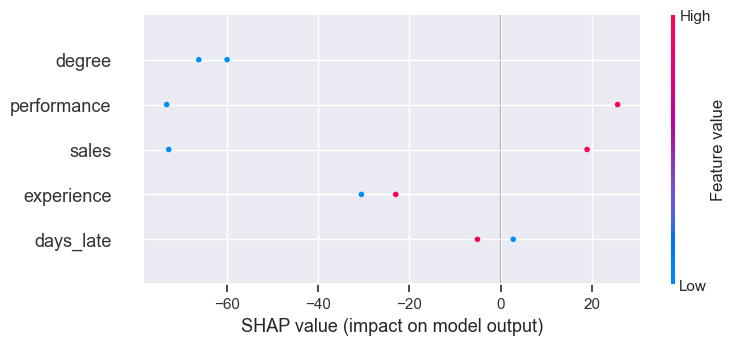

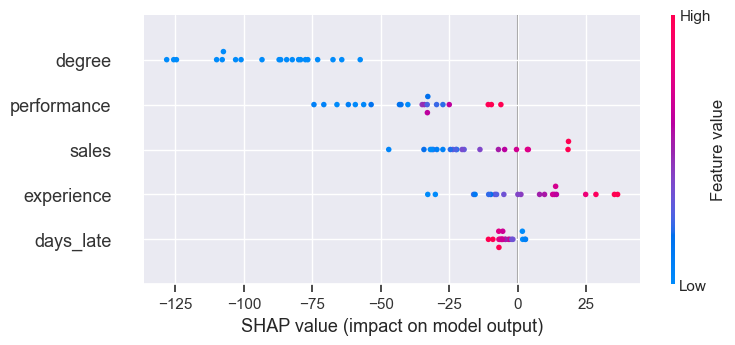

In [41]:
shap.plots.beeswarm(shap_values_1)
shap.plots.beeswarm(shap_values_0)

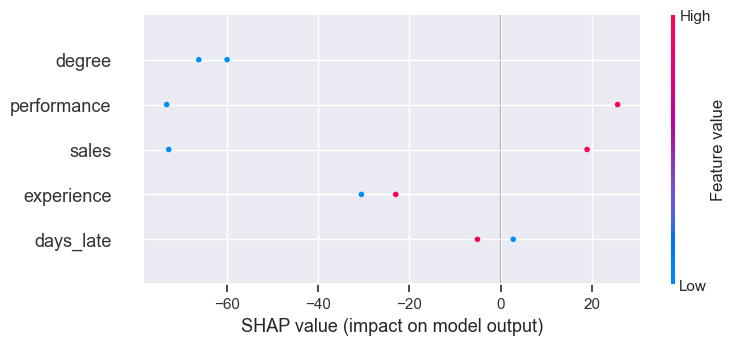

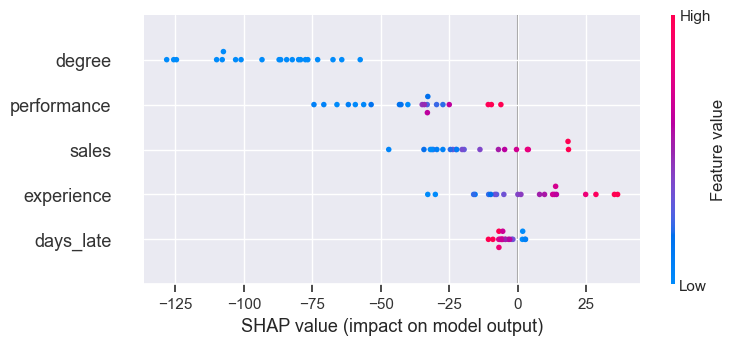

In [42]:
shap.plots.beeswarm(shap_values_1)
shap.plots.beeswarm(shap_values_0)

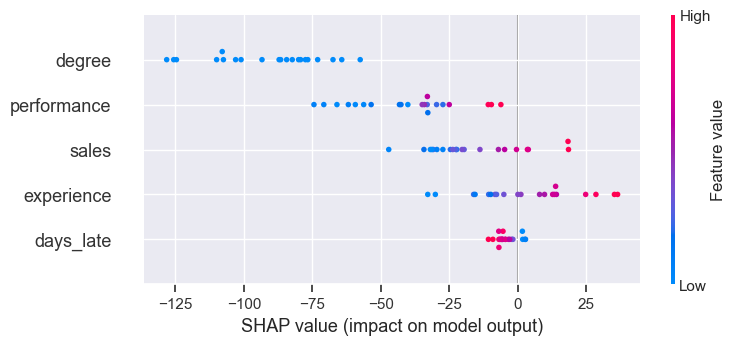

In [43]:
# Get order of features in SHAP plot for postive target variable
shap_mean = np.abs(shap_values_1.values).mean(0)
order = range(len(shap_mean))
order = [x for _,x in sorted(zip(shap_mean,order),reverse=True)]

shap.plots.beeswarm(shap_values_0,order = order)

In [44]:
color=['#FF0156' if y_==1 else '#535353' for y_ in y]


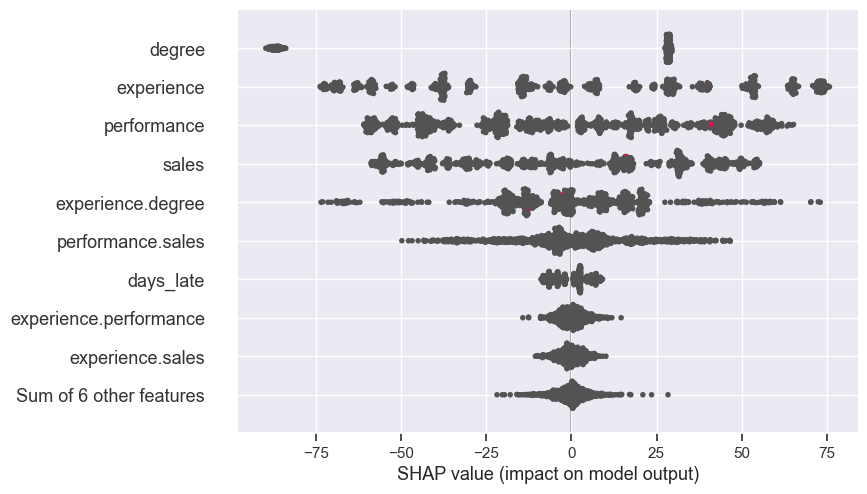

In [45]:
shap.plots.beeswarm(shap_values,color=color,color_bar=True)

In [46]:
shap_0 = pd.DataFrame(shap_interaction[0],index=X.columns,columns=X.columns)
shap_0['experience']['experience'] 

-6.4125648

In [47]:
shap_values[0]

.values =
array([-6.41256475e+00,  3.91168952e+00,  5.88356209e+00,  4.01607037e+00,
        4.83542681e-02, -8.79261703e+01,  3.01671600e+00, -1.39396667e+00,
       -8.87092590e-01, -4.39116859e+01,  1.56981220e+01, -3.03537369e-01,
       -2.48610668e+01,  1.51011467e+00, -3.95292950e+00])

.base_values =
151.52916

.data =
array([19.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        1.74,  0.  ,  0.  , 32.  ,  0.  , 15.  ])

In [48]:
np.shape(shap_values.values)

(1000, 15)

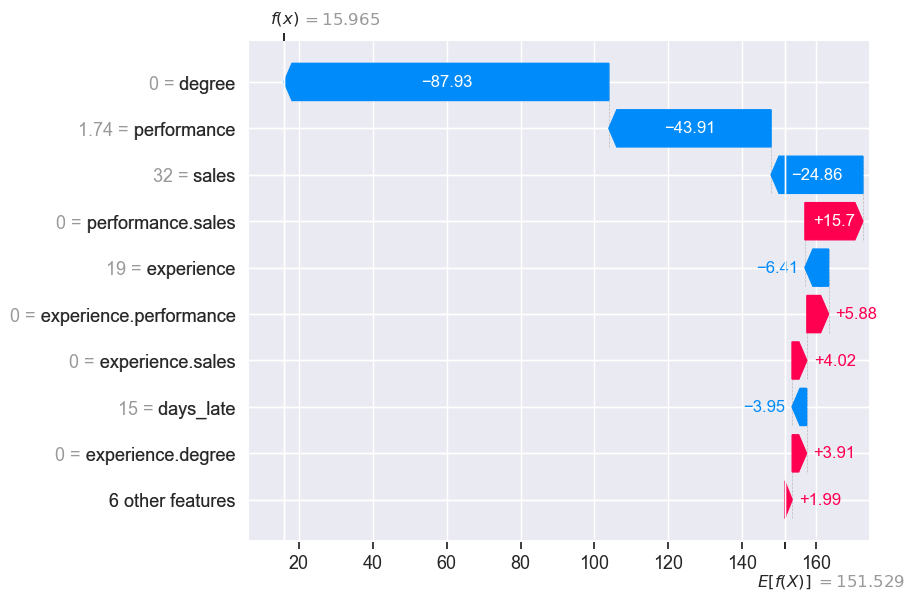

In [31]:
# Interaction waterfall
shap.plots.waterfall(shap_values[0])